## MiniLab SVM and Logistic Regression Modeling
### Data Mining 7331 Section 403
---
- Brian Coari
- Stephen Merritt
- Cory Thigpen
- Quentin Thomas

In this lab we will create a logistic regression model and a support vector machine model for podium finishes in the `Olympic` data set. We will assess how well each model performs and adjust model parameters to improve accuracy.

### Creating the Models

#### Data Augmentation and Preprocessing

To prepare the lab, we brought population data into the data set and changed all National Olympic Committee or `NOC` data points to match their corresponding `country`. For countries without entries in the worldbank URL we hard-coded the populations.

There were 106 observations in the data set not associated with a country, so we dropped them. These were `Refugee Athletes` and `Individual Olympic Athletes`.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Combine existing data with population data from:
#https://data.world/worldbank/total-population-per-country/file/POP_TOTAL_DS2_en_v2.csv
df = pd.read_csv('data/athletes_cleaned_merged.csv')
df_pop = pd.read_csv('data/POP_TOTAL.csv', encoding = "ISO-8859-1")
df_pop = df_pop[["Country Code", "2015"]]
#Change all Russia NOCs
df["NOC"] = np.where(df["NOC"] == "EUN", "RUS", df["NOC"])
df["NOC"] = np.where(df["NOC"] == "URS", "RUS", df["NOC"])
#Change all Australia NOCs
df["NOC"] = np.where(df["NOC"] == "ANZ", "AUS", df["NOC"])
#Change all German NOCs
df["NOC"] = np.where(df["NOC"] == "FRG", "GER", df["NOC"])
df["NOC"] = np.where(df["NOC"] == "GDR", "GER", df["NOC"])
df["NOC"] = np.where(df["NOC"] == "SAA", "GER", df["NOC"])
#Change all Congo NOCs
df["NOC"] = np.where(df["NOC"] == "CGO", "COD", df["NOC"])
#Change all Czech NOCs
df["NOC"] = np.where(df["NOC"] == "BOH", "CZE", df["NOC"])
df["NOC"] = np.where(df["NOC"] == "TCH", "CZE", df["NOC"])
#Change all Yemen NOCs
df["NOC"] = np.where(df["NOC"] == "YAR", "YEM", df["NOC"])
df["NOC"] = np.where(df["NOC"] == "YMD", "YEM", df["NOC"])
#Change all Greek NOCs
df["NOC"] = np.where(df["NOC"] == "CRT", "GRE", df["NOC"])
#Change all Zimbabwe NOCs
df["NOC"] = np.where(df["NOC"] == "RHO", "ZIM", df["NOC"])
#Change all Malaysia NOCs
df["NOC"] = np.where(df["NOC"] == "MAL", "MAS", df["NOC"])
df["NOC"] = np.where(df["NOC"] == "NBO", "MAS", df["NOC"])
#Change all Vietnam NOCs
df["NOC"] = np.where(df["NOC"] == "VNM", "VIE", df["NOC"])
#Change all Trinidad and Tobego NOCs
df["NOC"] = np.where(df["NOC"] == "WIF", "TTO", df["NOC"])
#Change all Trinidad and Tobego NOCs
df["NOC"] = np.where(df["NOC"] == "UAR", "SYR", df["NOC"])
#Change all Serbian NOCs
df["NOC"] = np.where(df["NOC"] == "SCG", "YUG", df["NOC"])
df["NOC"] = np.where(df["NOC"] == "SRB", "YUG", df["NOC"])
#Change all Canada NOCs
df["NOC"] = np.where(df["NOC"] == "NFL", "CAN", df["NOC"])
df_pop.rename(index = str, columns = {"Country Code" : "NOC", "2015": "2015 Population"}, inplace = True)
df_pop_merge = pd.merge(left = df, right = df_pop, how = "left", on=["NOC"], left_index=False)
df_pop_merge.loc[df_pop_merge["Country"] == "Taiwan", "2015 Population"] =  23485755
df_pop_merge.loc[df_pop_merge["Country"] == "Saint Vincent", "2015 Population"] =  109643
df_pop_merge.loc[df_pop_merge["Country"] == "Palestine", "2015 Population"] =  4817000
df_pop_merge.loc[df_pop_merge["Country"] == "Cook Islands", "2015 Population"] =  17459
df_pop_merge.loc[df_pop_merge["Country"] == "Eritrea", "2015 Population"] =  4846976
df_pop_merge.loc[df_pop_merge["Country"] == "Saint Kitts", "2015 Population"] =  54821
df_pop_mergena = df_pop_merge[df_pop_merge["2015 Population"].isnull()]
print(df_pop_mergena.groupby(["NOC", "Country"])["NOC"].count())
#Drop the 106 observations not associated with a country
df_pop_merge = df_pop_merge.dropna(how = "any")

/Users/osknowsys/anaconda3/envs/olympics/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


NOC  Country             
AHO  Curacao                    79
ALG  Algeria                   551
ANG  Angola                    267
ANT  Antigua                   133
ARU  Aruba                      42
ASA  American Samoa             37
BAH  Bahamas                   374
BAN  Bangladesh                 55
BAR  Barbados                  219
BER  Bermuda                   212
BHU  Bhutan                     36
BIZ  Belize                     76
BOT  Botswana                   90
BRU  Brunei                     10
BUL  Bulgaria                 3525
BUR  Burkina Faso               44
CAM  Cambodia                   63
CAY  Cayman Islands             83
CHA  Chad                       41
CRC  Costa Rica                264
CRO  Croatia                   876
DEN  Denmark                  3466
ESA  El Salvador               214
FIJ  Fiji                      232
GAM  Gambia                     56
GBS  Guinea-Bissau              21
GEQ  Equatorial Guinea          40
GER  Germany                 

Athlete `BMI` was calculated and added to the dataframe:

$$
BMI = \left(\frac{\omega}{\eta \eta}\right) C
$$

where $\omega$ represents `weight` in kilograms, $\eta$ represents `height` in centimeters, and $C$ is our constant at `10,000`.

In [2]:
from pandas.plotting import scatter_matrix
def calculate_bmi(df):
    return (df[1]/(df[0] * df[0])) * 10000

df_pop_merge['BMI'] = df_pop_merge[['Height', 'Weight']].apply(calculate_bmi, axis=1)
#df_pop_merge['Proportion_Athletes'] = df_pop_merge['2015 Population'].groupby(df_pop_merge['Country']).transform(lambda x: x / sum(x))
df_pop = df_pop_merge.groupby(['Country'])['2015 Population'].mean().reset_index()
df_pop['Population_Prop'] = df_pop['2015 Population'].transform(lambda x: x / (x.sum()))
df_pop_merge = pd.merge(left = df_pop_merge, right = df_pop, how = 'left', on=['Country'], 
                        left_index=False)
df_pop_merge = df_pop_merge[['Country', 'Sex', 'Age', 'Height', 'Weight', 'Year', 'Season', 'Sport', 'Event', 'BMI', 
                             'Population_Prop', 'Medal']]
df_pop_merge.to_csv('data/pop_merge.csv')
df_pop_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206535 entries, 0 to 206534
Data columns (total 12 columns):
Country            206535 non-null object
Sex                206535 non-null object
Age                206535 non-null float64
Height             206535 non-null float64
Weight             206535 non-null float64
Year               206535 non-null float64
Season             206535 non-null object
Sport              206535 non-null object
Event              206535 non-null object
BMI                206535 non-null float64
Population_Prop    206535 non-null float64
Medal              206535 non-null object
dtypes: float64(6), object(6)
memory usage: 20.5+ MB


Notice the `Id`, `NOC`, `Name`, `Team`, and `Games` variables were dropped due to lack of relevancy. Next we begin to change `Sex`, `Season`, and `Medal` to numeric factors with binary encoding.

In [3]:
df_pop_merge.loc[df_pop_merge['Medal'] == 'No Medal', 'Medal'] =  0
df_pop_merge.loc[df_pop_merge['Medal'] == 'Bronze', 'Medal'] =  1
df_pop_merge.loc[df_pop_merge['Medal'] == 'Silver', 'Medal'] =  1
df_pop_merge.loc[df_pop_merge['Medal'] == 'Gold', 'Medal'] =  1
df_pop_merge.loc[df_pop_merge['Season'] == 'Summer', 'Season'] =  1
df_pop_merge.loc[df_pop_merge['Season'] == 'Winter', 'Season'] =  0
df_pop_merge.loc[df_pop_merge['Sex'] == 'M', 'Sex'] =  1
df_pop_merge.loc[df_pop_merge['Sex'] == 'F', 'Sex'] =  0


y = df_pop_merge['Medal']
X = df_pop_merge.drop(['Medal'], axis = 1)

print(X.info())
print(y.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206535 entries, 0 to 206534
Data columns (total 11 columns):
Country            206535 non-null object
Sex                206535 non-null int64
Age                206535 non-null float64
Height             206535 non-null float64
Weight             206535 non-null float64
Year               206535 non-null float64
Season             206535 non-null int64
Sport              206535 non-null object
Event              206535 non-null object
BMI                206535 non-null float64
Population_Prop    206535 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 18.9+ MB
None
count    206535.000000
mean          0.152028
std           0.359048
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Medal, dtype: float64


`Country`, `Event`, and `Sport` have too many variables to perform this type of manipulation, so we move to one-hot encoding.

**OneHot Encode object variables**



In [4]:
X = pd.get_dummies(X, columns = ['Country', 'Event', 'Sport'])
print(X.describe())

                Sex            Age         Height         Weight  \
count  206535.00000  206535.000000  206535.000000  206535.000000   
mean        0.71585      25.322940     175.310547      70.902359   
std         0.45101       5.794613       9.924528      13.411201   
min         0.00000      11.000000     127.000000      25.000000   
25%         0.00000      21.000000     168.000000      62.000000   
50%         1.00000      24.436782     176.000000      71.000000   
75%         1.00000      28.000000     181.212532      78.040567   
max         1.00000      72.000000     226.000000     214.000000   

                Year         Season            BMI  Population_Prop  \
count  206535.000000  206535.000000  206535.000000    206535.000000   
mean     1979.173816       0.811756      22.891871         0.020719   
std        29.726482       0.390908       2.729093         0.041605   
min      1896.000000       0.000000       8.360954         0.000002   
25%      1960.000000       1.000

We begin building the logistic regression model. First we split the data into train and test, where 20% of observations are reserved for the test set. In addition, we run the model through a standard scaler operation. This is done in order to interpret all model weights on the same spectrum.

#### Logistic Regression Model Building

In [5]:
#Split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
#Standardize the train and test set
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
#Run the Logistic Regression Model with 
lr = LogisticRegression(penalty = 'l2', C = 0.01, random_state = 1)
#Use random feature elimination to determine most effective features to keep in the model

In [7]:
%%time
#Fit the Logistic Regression Model
lr1_clf = lr.fit(X_train_std, y_train)

CPU times: user 43.2 s, sys: 1.02 s, total: 44.3 s
Wall time: 44.3 s


In [8]:
print(lr1_clf.score(X_train, y_train))
print(lr1_clf.predict_proba(X_test_std[:10, :]))

0.8479737090565763
[[0.77772521 0.22227479]
 [0.9435152  0.0564848 ]
 [0.97345591 0.02654409]
 [0.56445791 0.43554209]
 [0.91652102 0.08347898]
 [0.72678174 0.27321826]
 [0.985205   0.014795  ]
 [0.79699719 0.20300281]
 [0.96877687 0.03122313]
 [0.6571741  0.3428259 ]]


In [9]:
print(lr1_clf.predict_proba(X_test_std[:10, :]).argmax(axis = 1))

[0 0 0 0 0 0 0 0 0 0]


In [10]:
%%time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
accuracies = cross_val_score(lr1_clf, X_train_std, y_train, cv=3) 
y_train_pred = cross_val_predict(lr1_clf, X_train_std, y_train, cv = 3)
lr1_clf_precision = precision_score(y_train, y_train_pred)
lr1_clf_recall = recall_score(y_train, y_train_pred)
print('Basic Logistic Regression Accuracies: ')
print(accuracies)
print('Model Precision: %0.3f' % (lr1_clf_precision))
print('Model Recal: %0.3f' % (lr1_clf_recall))

Basic Logistic Regression Accuracies: 
[0.85409253 0.85387465 0.85485511]
Model Precision: 0.584
Model Recal: 0.145
CPU times: user 2min 58s, sys: 7.98 s, total: 3min 6s
Wall time: 2min 56s


In [11]:
total = sum([0.85, 0.85, 0.84]) / 3
print("Accuracy Accross 3 Folds: ", total)

Accuracy Accross 3 Folds:  0.8466666666666667


In [12]:
from sklearn.metrics import classification_report

y_true, y_pred = y_test, lr1_clf.predict(X_test_std)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.98      0.92     35027
          1       0.60      0.15      0.24      6280

avg / total       0.83      0.86      0.82     41307



### SGD Classifier Linear Model

Next we examine the same dataset on a different model to determine the accuracy we can acheive. 

In [13]:
%%time
from sklearn.linear_model import SGDClassifier


sgd_classifier = SGDClassifier(max_iter=1000, n_jobs=-1, random_state=12, penalty='l2')
sgd_classifier.fit(X_train_std, y_train)

y_true, y_pred = y_test, sgd_classifier.predict(X_test_std)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92     35027
          1       0.70      0.04      0.08      6280

avg / total       0.83      0.85      0.79     41307

CPU times: user 3min 26s, sys: 414 ms, total: 3min 26s
Wall time: 3min 26s


With an $\alpha$ of `0.0001` and an $\epsilon$ of `0.1` we were able to achieve an average accruacy of 83%. For regularization we used the `l2` penalty in order to reach our most optimal classification.

### Discuss Model Advantages
---

#### Logistic Regression Results

First we tried the Logistic regression model on the entire dataset. We used a 3 fold cross validation in order to determine our final accuracy. The following Logistic Regression model used the following parameters...

|Param      | value|
|:---------:|:------:|
| Penalty    | L2    |
| C         |  0.01  |
| cv        |   3    |
| Dataset   | Full   |


The model above produced an accuracy of 83% during testing. In order to score the model we had to use precision and recall as a scoring metric as we are dealing with a binary classification method. The results are listed below...


|Class  | Precision  | Recall  |f1-score |  Support    |
|:-----:|:---------:|:-------:|:--------:|:------------:|
| 0 No Medal | 0.87 | 0.98    | 0.92     | 35027 |
| 1 Medal    | 0.60 | 0.15    | 0.24     | 6280  |
| avg / total | 0.83 | 0.86   | 0.82     | 41307|

`LR Runtime 2min 56sec`

We can see above that it was much easier for the model to tackle the No medal class because of the simple fact 85% of all the athletes falls into this category. It makes sense that it would be able to learn to classifier this category pretty quickly as our dataset is not exactly representative when it comes to medal winners.


#### SGD Linear Classifier Results

The next model was the Linear `SGD` model. This model used the following parameters...

|Param      | value|
|:---------:|:--------:|
| Penalty    | L2     |
| $\alpha$   |  0.0001|
| $\epsilon$ |   0.1  |
| Dataset   | Full   |


|Class | Precision | Recall | f1-score | Support |
|:-----:|:---------:|:--------:|:-------:|:--------:|
| 0 No Medal | 0.85 | 1.00  | 0.92 | 35027 |
| 1 Medal    | 0.70 | 0.04 | 0.08 | 6280|
| avg / total | 0.83| 0.85 | 0.79 | 41307|


`SGD Runtime 3min 26sec`


This model held a 83% accuracy during testing on the dataset. The model trained much slower than n the `LRM` so if we wanted to sacrifice precision and recall for the sake of the speed of training time the logistic regression model would be the best choice.


#### SVC Classifier

Finally we located a reduced dataset using the RFE feature selection technique. This reduction in the dimensionality of data allowed us to take a SVM based approach to the data. Without reducing the dataset down it took an extra long time for our dataset to converge. The paramters we used to train this dataset are listed below...

|Param      | value|
|:---------:|:--------:|
| Kernel    | rbf      |
| C         |  1000     |
| $\gamma$ |   0.001    |
| Dataset   | Reduced   |




|Class | Precision | Recall | f1-score | Support |
|:-----:|:---------:|:--------:|:-------:|:--------:|
| 0 No Medal | 0.85 | 1.00  | 0.92 | 35027 |
| 1 Medal    | 0.87 | 0.03 | 0.05 | 6280|
| avg / total | 0.85| 0.85 | 0.79 | 41307|


`SVC Runtime 51min 31sec`

SVC using the `rbf` kernel produces a better accuracy, but where we gain in accuracy we lose in performance. It took almost an hour for the model to converge! This is something that we would need to think long and hard about if we decided to model this dataset with this particular model.

Logistic Regression across 3 folds showed that it can receive an accuracy of 84% on our specific dataset. The good thing with this model is that it is so much easier to interpret the paramters and the probability in relation to our classification problem. The training time for this particular model was much faster than the SGD Classifier by a few minutes. This model also took into consideration that the no medal and medal classes were unevenly weighted, so 92% is much closer to a true accuracy.


### Interperet Feature Importance
We will use the weights from logistic regression to interpret the importance of different features for `medal` winners. To do this we will split the data into train and test once again then run the model through a standard scaler operation. Lastly, we will run the logistic regression again.

In [19]:
%%time
from sklearn.feature_selection import RFE
#Use Recursive Feature elimination to determine feature importance
#FITTING THIS MODEL WILL TAKE AT LEAST 60 MINUTES TO FIT THE RFE model 
rfe = RFE(lr, n_features_to_select = 1, verbose = True)
rfe_clf = rfe.fit(X_train_std, y_train)

Fitting estimator with 704 features.
Fitting estimator with 703 features.
Fitting estimator with 702 features.
Fitting estimator with 701 features.
Fitting estimator with 700 features.
Fitting estimator with 699 features.
Fitting estimator with 698 features.
Fitting estimator with 697 features.
Fitting estimator with 696 features.
Fitting estimator with 695 features.
Fitting estimator with 694 features.
Fitting estimator with 693 features.
Fitting estimator with 692 features.
Fitting estimator with 691 features.
Fitting estimator with 690 features.
Fitting estimator with 689 features.
Fitting estimator with 688 features.
Fitting estimator with 687 features.
Fitting estimator with 686 features.
Fitting estimator with 685 features.
Fitting estimator with 684 features.
Fitting estimator with 683 features.
Fitting estimator with 682 features.
Fitting estimator with 681 features.
Fitting estimator with 680 features.
Fitting estimator with 679 features.
Fitting estimator with 678 features.
F

Fitting estimator with 482 features.
Fitting estimator with 481 features.
Fitting estimator with 480 features.
Fitting estimator with 479 features.
Fitting estimator with 478 features.
Fitting estimator with 477 features.
Fitting estimator with 476 features.
Fitting estimator with 475 features.
Fitting estimator with 474 features.
Fitting estimator with 473 features.
Fitting estimator with 472 features.
Fitting estimator with 471 features.
Fitting estimator with 470 features.
Fitting estimator with 469 features.
Fitting estimator with 468 features.
Fitting estimator with 467 features.
Fitting estimator with 466 features.
Fitting estimator with 465 features.
Fitting estimator with 464 features.
Fitting estimator with 463 features.
Fitting estimator with 462 features.
Fitting estimator with 461 features.
Fitting estimator with 460 features.
Fitting estimator with 459 features.
Fitting estimator with 458 features.
Fitting estimator with 457 features.
Fitting estimator with 456 features.
F

Fitting estimator with 260 features.
Fitting estimator with 259 features.
Fitting estimator with 258 features.
Fitting estimator with 257 features.
Fitting estimator with 256 features.
Fitting estimator with 255 features.
Fitting estimator with 254 features.
Fitting estimator with 253 features.
Fitting estimator with 252 features.
Fitting estimator with 251 features.
Fitting estimator with 250 features.
Fitting estimator with 249 features.
Fitting estimator with 248 features.
Fitting estimator with 247 features.
Fitting estimator with 246 features.
Fitting estimator with 245 features.
Fitting estimator with 244 features.
Fitting estimator with 243 features.
Fitting estimator with 242 features.
Fitting estimator with 241 features.
Fitting estimator with 240 features.
Fitting estimator with 239 features.
Fitting estimator with 238 features.
Fitting estimator with 237 features.
Fitting estimator with 236 features.
Fitting estimator with 235 features.
Fitting estimator with 234 features.
F

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 fea

In [20]:
print("Features sorted by their rank:")
names = X.columns
sorted(zip(map(lambda x: round(x, 4), rfe_clf.ranking_), names))

Features sorted by their rank:


[(1, 'Country_USA'),
 (2, 'Country_Russia'),
 (3, 'Weight'),
 (4, 'Year'),
 (5, 'Sex'),
 (6, 'Country_Luxembourg'),
 (7, 'Country_Egypt'),
 (8, 'Sport_Athletics'),
 (9, 'Season'),
 (10, 'Event_Ice  Ice Hockey'),
 (11, 'Event_ Individual All-Around'),
 (12, 'Event_ Road Race, Individual'),
 (13, 'Event_ Rugby'),
 (14, 'Event_ Floor Exercise'),
 (15, 'Event_ Horse Vault'),
 (16, 'Sport_Alpine Skiing'),
 (17, 'Event_ Team All-Around, Swedish System'),
 (18, 'Event_ Horizontal Bar'),
 (19, 'Country_Mexico'),
 (20, 'Event_ Uneven Bars'),
 (21, 'Event_ Pommelled Horse'),
 (22, 'Country_Senegal'),
 (23, 'Event_ Parallel Bars'),
 (24, 'Event_ Rings'),
 (25, 'Country_Ireland'),
 (26, 'Country_Venezuela'),
 (27, 'Event_ Balance Beam'),
 (28, 'Country_Israel'),
 (29, 'Event_Sailing Mixed 12 metres'),
 (30, 'Event_ Lacrosse'),
 (31, 'Country_Cyprus'),
 (32, 'Event_ Foil, Individual'),
 (33, 'Country_Colombia'),
 (34, 'Event_ epee, Individual'),
 (35, 'Country_San Marino'),
 (36, 'Event_ 4 x 100 me

In [21]:
#Updated Model based on output from RFE function
ranks = sorted(zip(map(lambda x: round(x, 4), rfe_clf.ranking_), names))[:30]

best_features = []
[best_features.append(t[1]) for t in ranks]
X_reduced = X[best_features]
print(X_reduced.head())

   Country_USA  Country_Russia     Weight    Year  Sex  Country_Luxembourg  \
0            0               0  73.343761  1956.0    1                   0   
1            0               0  73.343761  1936.0    1                   0   
2            0               0  73.086644  1948.0    1                   0   
3            0               0  48.000000  1980.0    1                   0   
4            0               0  76.400640  1964.0    1                   0   

   Country_Egypt  Sport_Athletics  Season  Event_Ice  Ice Hockey  \
0              0                0       1                      0   
1              0                0       1                      0   
2              0                0       1                      0   
3              0                0       1                      0   
4              0                0       1                      0   

        ...         Event_ Pommelled Horse  Country_Senegal  \
0       ...                              0                0

In [22]:
#Split the data set into train and test
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_reduced, y, test_size = 0.2, random_state = 1, stratify = y)
#Standardize the train and test set
sc = StandardScaler()
sc.fit(X_train1)
X_train_std1 = sc.transform(X_train1)
X_test_std1 = sc.transform(X_test1)

#Run the Logistic Regression Model with 
lr_reduced = LogisticRegression(penalty = 'l2', C = 0.01, random_state = 1)
lr2_clf = lr_reduced.fit(X_train_std1, y_train1)

In [23]:
print(lr2_clf.score(X_train1, y_train1))
print(lr2_clf.predict_proba(X_test_std1[:10, :]))

0.8479737090565763
[[0.81393894 0.18606106]
 [0.83754795 0.16245205]
 [0.93767515 0.06232485]
 [0.85336696 0.14663304]
 [0.89115192 0.10884808]
 [0.75137593 0.24862407]
 [0.8518357  0.1481643 ]
 [0.76448216 0.23551784]
 [0.83415753 0.16584247]
 [0.74536215 0.25463785]]


In [24]:
print(lr2_clf.predict_proba(X_test_std1[:10, :]).argmax(axis = 1))

[0 0 0 0 0 0 0 0 0 0]


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
accuracies = cross_val_score(lr2_clf, X_train_std1, y=y_train1, cv=3) # this also can help with parallelism
y_train_pred = cross_val_predict(lr2_clf, X_train_std1, y_train1, cv = 3)
lr2_clf_precision = precision_score(y_train1, y_train_pred)
lr2_clf_recall = recall_score(y_train1, y_train_pred)
print(accuracies)
print(lr2_clf_precision)
print(lr2_clf_recall)

[0.8503704  0.84949887 0.85053381]
0.6353297952994693
0.03336120068474063


In [26]:
from sklearn import metrics as mt
y_hat = lr2_clf.predict(X_test_std1) # get test set precitions

# now let's get the accuracy and confusion matrix for this iterations of training/testing
acc = mt.accuracy_score(y_test1,y_hat)
conf = mt.confusion_matrix(y_test1,y_hat)
print("accuracy", acc )
print("confusion matrix\n",conf)

accuracy 0.8502675091388868
confusion matrix
 [[34896   131]
 [ 6054   226]]


The confusion matrix above shows the prediction results using a logistic regression. The regression made 53,370 predictions of which 45,629 or 85% were correct.

Next, we compare the weights of the two models. Once the weights have been scaled we plot them with pandas. This plot will help to interpret the model as we see the relative feature weights of the balanced model. and then plot.

*Is this step interpretted right? Felt like I missed how we went from two vectors into one.*

In [27]:
#Compare the weights of the two models
#iterate over the coefficients
weights_lr1 = lr1_clf.coef_.T
#take transpose to make a column vector
variable_names_lr1 = X.columns
for coef, name in zip(weights_lr1,variable_names_lr1):
    print(name, 'has weight of', coef[0])

Sex has weight of -0.1802313394633457
Age has weight of 0.08881541833925796
Height has weight of 0.027167545870139545
Weight has weight of 0.15645083290543857
Year has weight of -0.17608876709458424
Season has weight of 0.18357663796844512
BMI has weight of -0.02263147415929608
Population_Prop has weight of 0.10132394599949347
Country_Afghanistan has weight of -0.07228505255920781
Country_Albania has weight of -0.06028545364665052
Country_Andorra has weight of -0.08100218390538289
Country_Argentina has weight of -0.07098878231406693
Country_Armenia has weight of -0.007137774948017079
Country_Australia has weight of 0.06396767069683632
Country_Austria has weight of -0.02716769672012732
Country_Azerbaijan has weight of 0.018571270921923726
Country_Bahrain has weight of -0.017455500305704443
Country_Belarus has weight of -0.023797083906346998
Country_Belgium has weight of -0.056926976393189485
Country_Benin has weight of -0.06551591501914591
Country_Boliva has weight of -0.086557336976582

In [28]:
# iterate over the coefficients
weights_lr2 = lr2_clf.coef_.T
# take transpose to make a column vector
variable_names_lr2 = X_reduced.columns
for coef, name in zip(weights_lr2,variable_names_lr2):
    print(name, 'has weight of', coef[0])

Country_USA has weight of 0.30160201597797515
Country_Russia has weight of 0.30532257624084147
Weight has weight of 0.1632032335943952
Year has weight of -0.2032164622537426
Sex has weight of -0.17437780534206482
Country_Luxembourg has weight of -0.19851511821729528
Country_Egypt has weight of -0.20874738897888265
Sport_Athletics has weight of -0.24238093067759459
Season has weight of 0.28988806459645794
Event_Ice  Ice Hockey has weight of 0.19091383924674404
Event_ Individual All-Around has weight of -0.2175340180871954
Event_ Road Race, Individual has weight of -0.20092611916237496
Event_ Rugby has weight of 0.1760982584036075
Event_ Floor Exercise has weight of -0.17998598789865303
Event_ Horse Vault has weight of -0.17783187401353806
Sport_Alpine Skiing has weight of -0.1505868844584008
Event_ Team All-Around, Swedish System has weight of 0.15012737829970535
Event_ Horizontal Bar has weight of -0.15280821969450084
Country_Mexico has weight of -0.14788100977061955
Event_ Uneven Bars

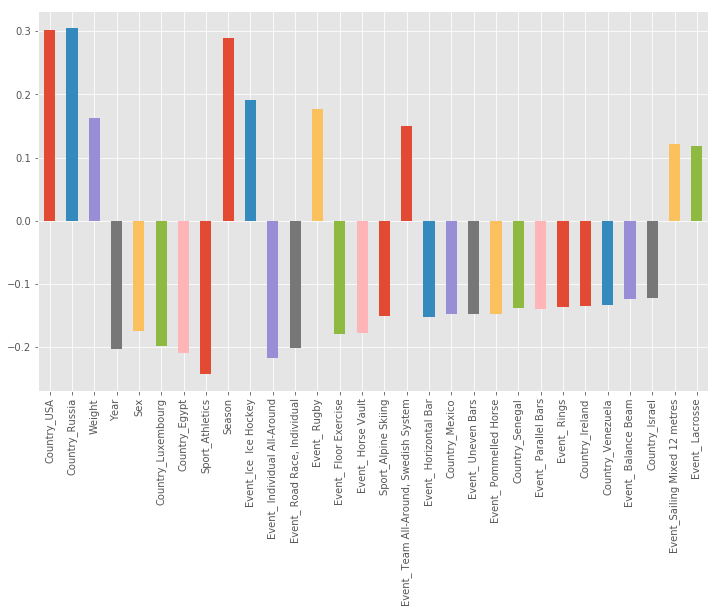

In [29]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr2_clf.coef_[0],index=X_reduced.columns)
weights.plot(kind='bar', figsize = (12, 7))
plt.show()

Lastly for the logistic regression we plot the ROC curve to visualize sensitivity and specificity of the test. 

In [30]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=lr2_clf, X=X_train1, y=y_train1, cv=10, scoring='roc_auc')
print("Logistic Regression ROC AUC: %0.2f, (+/- %0.2f)" % (scores.mean(), scores.std()))

Logistic Regression ROC AUC: 0.69, (+/- 0.01)


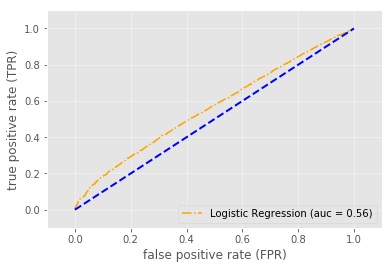

In [31]:
from sklearn.metrics import roc_curve, auc
y_pred = lr2_clf.predict_proba(X_test1)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true = y_test1, y_score = y_pred)
roc_auc = auc(x = fpr, y = tpr)
plt.plot(fpr, tpr, color = 'orange', linestyle = '-.', label = 'Logistic Regression (auc = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'blue', linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha = 0.5)
plt.xlabel('false positive rate (FPR)')
plt.ylabel('true positive rate (TPR)')
plt.legend(loc = 'lower right')
plt.show()

### Interpret Support Vectors
---

In [41]:
%%time
from sklearn.svm import SVC

svc = SVC(C=1000, gamma=0.001, kernel='rbf', random_state=12)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_reduced, y,
                                                        random_state = 1, stratify=y,
                                                       test_size=0.2)


sc.fit(X_train2)
X_train2_std = sc.transform(X_train2)
X_test2_std = sc.transform(X_test2)



svc.fit(X_train2_std, y_train2)

y_true, y_pred = y_test2, svc.predict(X_test2_std)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92     35027
          1       0.87      0.03      0.05      6280

avg / total       0.85      0.85      0.79     41307

CPU times: user 51min 31s, sys: 14.6 s, total: 51min 45s
Wall time: 51min 43s


In [37]:
sum(svc.n_support_)

49759

Above we can see that there are a total of 49759 support vectors when we look at our reduced dataset. We went from 194 features down to top 30 RFE features. These support vectors are broken by class by...

In [38]:
print("No Medal Class Number of Support Vectors :", svc.n_support_[0])
print("Medal Class Number of support Vectors : ", svc.n_support_[1])

No Medal Class Number of Support Vectors : 25009
Medal Class Number of support Vectors :  24750


This makes sense that The No medal class has a larger number of support vectors as there are more possibilities of not winning a medal in our dataset than there is of someone actually winning a medal.

In [43]:
svc.support_

array([    10,     18,     30, ..., 165221, 165223, 165227], dtype=int32)

In [40]:
X_reduced.iloc[10, :]

Country_USA                                  0.000000
Country_Russia                               0.000000
Weight                                      73.343761
Year                                      1948.000000
Sex                                          1.000000
Country_Luxembourg                           0.000000
Country_Egypt                                0.000000
Sport_Athletics                              0.000000
Season                                       1.000000
Event_Ice  Ice Hockey                        0.000000
Event_ Individual All-Around                 0.000000
Event_ Road Race, Individual                 0.000000
Event_ Rugby                                 0.000000
Event_ Floor Exercise                        0.000000
Event_ Horse Vault                           0.000000
Sport_Alpine Skiing                          0.000000
Event_ Team All-Around, Swedish System       0.000000
Event_ Horizontal Bar                        0.000000
Country_Mexico              

If we examine our support vectors found by the SVC model, We can see that Russia and the United States are huge factors in determining whether or not an athelete does not win a medal. This finding corresponds to the fact that those two Countries had the most medal winners in the dataset. Not being from those countries is more likely to result in a athlete not having a podium finish. `Sex` seems to determine whether a athlete will win a Gold medal. This Might have something to do with the fact that Men had more data available for their olympic finishes than women did. 1948 Seemed to be a significant year that the support vector found. This corresponds to the uptick in Gold Medal wins that our Gold Medals over time graph showed in our EDA section. Finally, we notice that a Weight of 73 Kilograms seems to be significant. The reason for this is unknown at the time, but could have something to do with lighter athletes more likely to engage in events where there were a greater number of Podium Finishes. Its also expected to see the Sport_Athletics show up as a Support Vector because some sports are more likely to produce a high number of podium finishes than others. Our Support Vectors found by the SVC model do seem to be linked with some of the initial findings we highlighted during EDA.

In [44]:
X_reduced.to_csv('data/reduced_olympic_data.csv', header=True, index=False)